/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_10105/354346013.py:138: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_10105/354346013.py:139: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


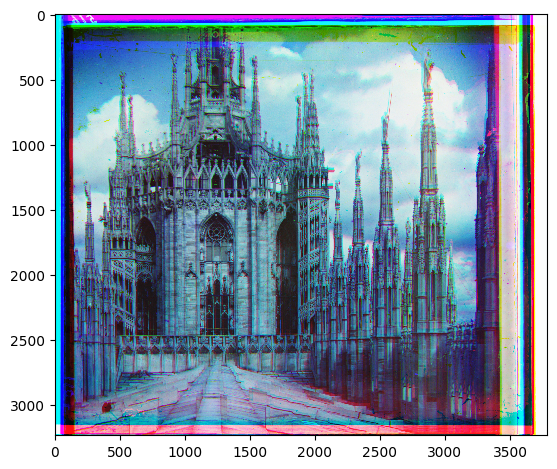

/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_10105/354346013.py:138: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_10105/354346013.py:139: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


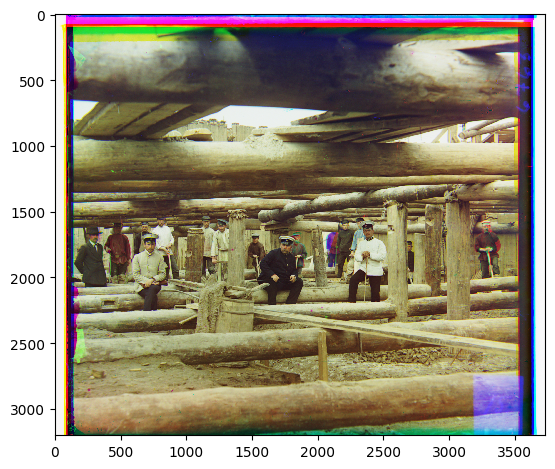

/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_10105/354346013.py:138: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_10105/354346013.py:139: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


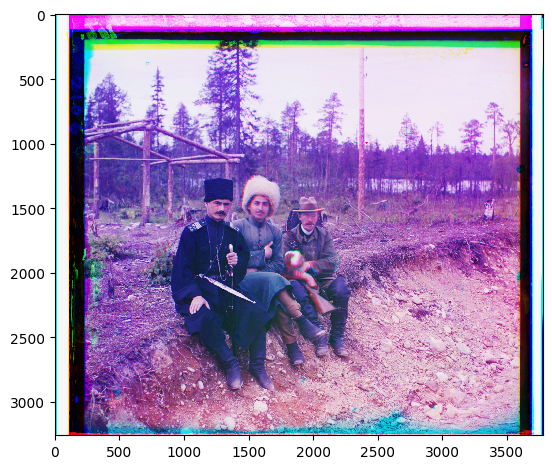

In [3]:
# CS180 (CS280A): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import cv2 as cv
import skimage as sk
import skimage.io as skio
from pathlib import Path
import time

# L2-Norm/Euclidean Distance
def l2_norm(image1, image2):
    return np.sqrt(np.sum(np.sum((image1-image2)**2)))

# Normalized Cross Correlation
def ncc(image1, image2):
    return np.sum(image1 * image2) / (np.linalg.norm(image1) * np.linalg.norm(image2))
    
#Match image1 onto image2
def align(image1, image2, method='l2', displacement_range=15):
    cur_best_diff = None
    cur_best_disp = None
    
    #fixed range of 15 pixels   
    search_range = range(-displacement_range, displacement_range+1)

    for y in search_range:
        for x in search_range:
            rolled_image = np.roll(image1, (x,y), axis=(0,1))
            if (method == 'l2'):
                metric_result = -l2_norm(rolled_image, image2)
            if (method == 'ncc'):
                metric_result = ncc(rolled_image, image2)
    
            if cur_best_diff == None or metric_result > cur_best_diff:
                cur_best_diff = metric_result
                cur_best_disp = (x, y)
    return np.array(cur_best_disp)

# image pyramid
def pyramid(image1, image2, method='ncc', displacement_range=15, pyramid_depth=5):
    if (len(image1) < 100 or pyramid_depth == 0):
        return align(image1, image2, method, displacement_range)
    
    cur_best_disp = pyramid(sk.transform.rescale(image1, 0.5), sk.transform.rescale(image2, 0.5), method, displacement_range, pyramid_depth=pyramid_depth-1)
    cur_best_disp *=2
    scaled_shift = align(np.roll(image1, tuple(cur_best_disp), axis=(0,1)), image2, method, displacement_range)
    cur_best_disp = cur_best_disp + scaled_shift
    return cur_best_disp

def align_helper(image1, image2, method='ncc', displacement_range=15, use_pyramid=True):
    if (use_pyramid == True):
        return pyramid(image1, image2, method, 5) # lower displacement for pyramid
    return align(image1, image2, method, displacement_range)

# sobel edge finding
# https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm
Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
def sobel(image):
    dx = cv.filter2D(src=image, ddepth=-1, kernel=Gx)
    dy = cv.filter2D(src=image, ddepth=-1, kernel=Gy)
    output = cv.magnitude(dx, dy)

    return threshold(output)

def crop(image, percent=.10):
    height, width = image.shape
    y_max = int(height * percent)
    x_max = int(width * percent)
    return image[y_max:-y_max, x_max:-x_max]

def threshold(image, percent=.20):
    output = np.zeros_like(image)

    thresholded_edges = image > percent
    output[thresholded_edges] = 1
    return output

# main process function
def process_image(imname):
    # read in the image
    start = time.perf_counter()
    im = skio.imread(imname)
    im = sk.img_as_float(im)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # pre-process
    r_crop = crop(r)
    g_crop = crop(g)
    b_crop = crop(b)

    if use_sobel:
        r_crop = sobel(r_crop)
        g_crop = sobel(g_crop)
        b_crop = sobel(b_crop)

    # align the images
    ag_disp = align_helper(g_crop, b_crop, method, use_pyramid=use_pyramid)
    ar_disp = align_helper(r_crop, b_crop, method, use_pyramid=use_pyramid)

    ag_disp = tuple(map(int, ag_disp))
    ar_disp = tuple(map(int, ar_disp))

    ar = np.roll(r, ar_disp, axis=(0,1))
    ag = np.roll(g, ag_disp, axis=(0,1))
    im_out = np.dstack([ar, ag, b])
    end = time.perf_counter()

    elapsed_time = end-start

    image_name = Path(imname).stem
    image_dir = Path(outdir/image_name)
    image_dir.mkdir(exist_ok=True)
    fname = image_dir / f"{image_name}_aligned.jpg"
    out_r = image_dir / f"{image_name}_R.jpg"
    out_g = image_dir / f"{image_name}_G.jpg"
    out_b = image_dir / f"{image_name}_B.jpg"
    out_info = image_dir / f"{image_name}_info.txt"

    skio.imsave(fname, sk.img_as_ubyte(im_out))
    skio.imsave(out_r, sk.img_as_ubyte(r_crop))
    skio.imsave(out_g, sk.img_as_ubyte(g_crop))
    skio.imsave(out_b, sk.img_as_ubyte(b_crop))
    with open(out_info, "w") as f:
        f.write(f"Green Displacement: {tuple(ag_disp)}\n")
        f.write(f"Red Displacement: {tuple(ar_disp)}\n")
        f.write(f"Alignment Time: {elapsed_time:.3f} seconds\n")

    # display output image
    skio.imshow(im_out)
    skio.show()

#set parameters here
method = 'ncc'
use_sobel = True
use_pyramid = True

# iterate over all images and output
data_dir = './cs180 proj1 data'
outdir = Path('./aligned_images')
outdir.mkdir(exist_ok=True)

#tifs
pathlist = Path(data_dir).glob('**/*.tif')
for path in pathlist:
    path_str = str(path)
    process_image(path_str)
#jpgs
pathlist = Path(data_dir).glob('**/*.jpg')
for path in pathlist:
    path_str = str(path)
    process_image(path_str)